In [1]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display, HTML
from transformers import DistilBertModel, DistilBertTokenizer, logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm_notebook
import seaborn as sns
import pandas as pd
import numpy as np
import collections
from collections import Counter
import glob
import pickle
import random
from scipy.special import softmax
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
import sys
from sklearn.preprocessing import LabelBinarizer
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from netgraph import Graph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
logging.set_verbosity_error()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sys.path.insert(0, '../../src/models/')
sys.path.insert(0, '../../src/features/')

In [3]:
# Own Functions
from build_features import similarity_matrix as vector_values
from predict_model import load_CUB_Bert, load_simBERT, loadBERT
from predict_model import SpanPredictor as classify

In [4]:
output = 549

In [5]:
model = load_CUB_Bert("../../models/", 'saved_weights_PlantSpecies_549.pt', outputsize=output)

Local Success


In [6]:
text_dict = pickle.load(open('../../data/processed/RDF_TEXT_TRAIN_V2_SET_554.pkl', 'rb'))
triples_dict = pickle.load(open('../../data/processed/RDF_TRIPLES_TRAIN_V2_SET_554.pkl', 'rb'))

In [188]:
lb = LabelBinarizer()
keys = np.array([key for key in text_dict.keys()])
keys_encoded = lb.fit_transform(keys)


species_list = list(triples_dict.keys())

In [190]:
#species_list[10:11]

In [8]:
def WhichPlant(span, model):
    
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation=True )
        # Predict class
        outputs = model(**inputs)
        # Detach
        outputs = outputs.detach().numpy()
    return np.squeeze(outputs)

In [9]:
softmax([0.5, 0.5, 1.867])

array([0.16881733, 0.16881733, 0.66236533])

In [ ]:
#text_dict['attalea butyracea']

In [149]:
importance_dict = collections.defaultdict(list)
RDF_dict = collections.defaultdict(list)

for plant in tqdm_notebook(species_list[10:20]):
    
    # Extract plant index
    i = np.where(lb.classes_ == plant)[0][0]
    # Set dimensions
    h, w = (len(text_dict[plant]), output)
    #logvalues = np.empty((h, w), float)
    logvalues = np.zeros((h), float)
    for idx, text in enumerate(text_dict[plant][0:]):
        probs = WhichPlant(text, model=model)
        logvalues[idx] = probs[i]
        
    probabilities = softmax(logvalues)
    
    for idx, (prob, triple) in enumerate(zip(probabilities, triples_dict[plant])):
        importance_dict[plant].append((prob, triple))
        
    #importance_dict[plant] = logvalues
    #text_dict[plant] = np.array(text_dict[plant])

  0%|          | 0/10 [00:00<?, ?it/s]

In [106]:
#importance_dict

In [150]:
RDF_dict_text = collections.defaultdict(list)

source   = []
relation = []
target   = []
colors   = {}
main_parts = []
sub_parts  = []
low = 1
high = 0

for species in species_list[10:11]:
    for color, (sub, rel, obj) in importance_dict[species]:
        

        
        source.append(sub)
        relation.append(rel)
        target.append(obj)
        colors[obj] = color
        if rel == 'has main part':
            main_parts.append(obj)
        if rel == 'has sub part':
            sub_parts.append(obj)
            
        if low > color:
            low = color
        if high < color:
            high = color
            
        ##
        
        
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

In [151]:
#norm = mcolors.Normalize(vmin=low, vmax=high)
norm = mcolors.LogNorm(vmin=low, vmax=high)
cmap = matplotlib.cm.RdYlGn

In [152]:
nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())


node_labels = {node : node for idx, node in enumerate(G)}
edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))

node_size = {}
node_color = {}


size = 1

for node in node_labels:
    
    #node_size[node] = 3.5/size
    if node == 'species':
        node_color[node] = 'white'
        node_size[node] = 4.5/size
    else:
        node_color[node] = cmap(norm(colors[node]))
        if node in main_parts:
            node_size[node] = 3.5/size
        elif node in sub_parts:
            node_size[node] = 2.5/size
        else:
            node_size[node] = 1.5/size
        
pos = nx.spring_layout(G, k = 0.023, iterations=100, seed=33, dim=2,scale=0.8, center=(0,0))


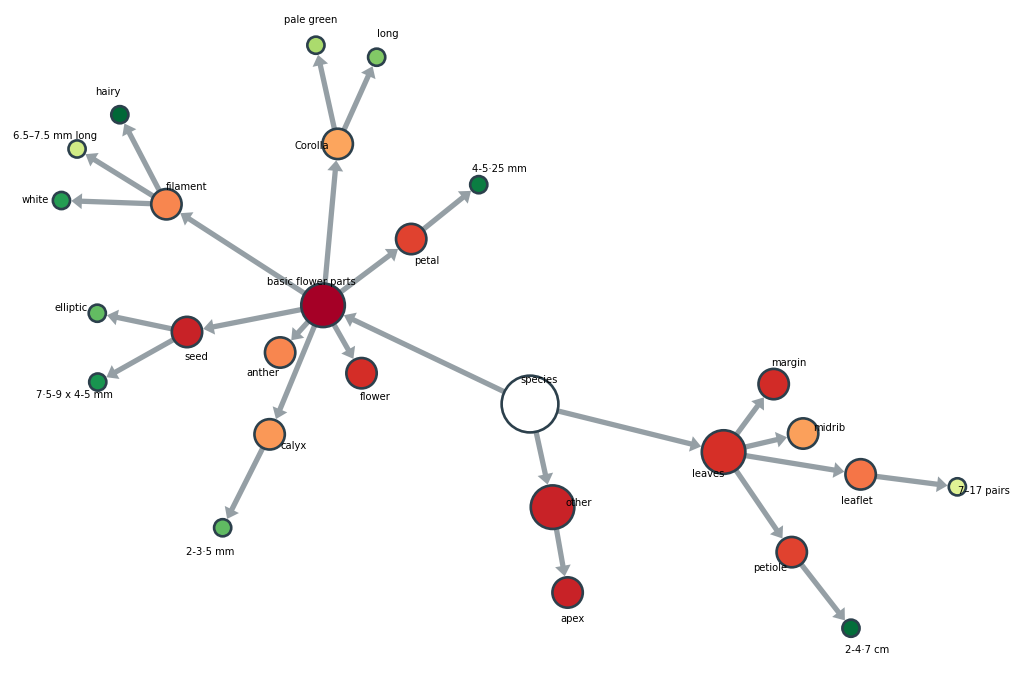

In [153]:
fig, ax = plt.subplots(figsize=(18, 18))
Graph(nodes, 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_labels=node_labels, 
      node_label_offset=0.04, 
      node_label_fontdict=dict(size=10, rotation=0, ha='center', clip_on=False), node_edge_width=0.4,
      node_size=node_size,  node_color=node_color, #edge_labels=edge_labels,
      edge_width=0.8, edge_label_fontdict=dict(size=5,),
      ax=ax)

In [ ]:
node_labels

# 1000 SPECIES

In [226]:
output=1000

In [227]:
model = load_CUB_Bert("../../models/", 'saved_weights_PlantSpecies_1000.pt', outputsize=output)

Local Success


In [228]:
text_dict = pickle.load(open('../../data/processed/RDF_TEXT_TRAIN_SET_1000.pkl', 'rb'))
triples_dict = pickle.load(open('../../data/processed/RDF_TRIPLES_TRAIN_SET_1000.pkl', 'rb'))

In [229]:
lb = LabelBinarizer()
keys = np.array([key for key in text_dict.keys()])
keys_encoded = lb.fit_transform(keys)


species_list = list(triples_dict.keys())

In [230]:
"Dichanthelium superatum" in species_list

True

In [231]:
species_list.index("Dichanthelium superatum")

33

In [232]:
def WhichPlant(span, model):
    
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation=True )
        # Predict class
        outputs = model(**inputs)
        # Detach
        outputs = outputs.detach().numpy()
    return np.squeeze(outputs)

In [233]:
importance_dict = collections.defaultdict(list)
RDF_dict = collections.defaultdict(list)

for plant in tqdm_notebook(species_list[33:34]):
    
    # Extract plant index
    i = np.where(lb.classes_ == plant)[0][0]
    # Set dimensions
    h, w = (len(text_dict[plant]), output)
    #logvalues = np.empty((h, w), float)
    logvalues = np.zeros((h), float)
    for idx, text in enumerate(text_dict[plant][0:]):
        probs = WhichPlant(text, model=model)
        logvalues[idx] = probs[i]
        
    probabilities = softmax(logvalues)
    
    for idx, (prob, triple) in enumerate(zip(probabilities, triples_dict[plant])):
        importance_dict[plant].append((prob, triple))
        
    #importance_dict[plant] = logvalues
    #text_dict[plant] = np.array(text_dict[plant])

  0%|          | 0/1 [00:00<?, ?it/s]

In [234]:
RDF_dict_text = collections.defaultdict(list)

source   = []
relation = []
target   = []
colors   = {}
main_parts = []
sub_parts  = []
low = 1
high = 0

for species in species_list[33:34]:
    for color, (sub, rel, obj) in importance_dict[species]:
        

        
        source.append(sub)
        relation.append(rel)
        target.append(obj)
        colors[obj] = color
        if rel == 'has main part':
            main_parts.append(obj)
        if rel == 'has sub part':
            sub_parts.append(obj)
            
        if low > color:
            low = color
        if high < color:
            high = color
            
        ##
        
        
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

In [239]:
#norm = mcolors.Normalize(vmin=low, vmax=high)
norm = mcolors.LogNorm(vmin=low, vmax=high)
cmap = matplotlib.cm.RdYlGn

In [240]:
#importance_dict

In [241]:
nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())


node_labels = {node : node for idx, node in enumerate(G)}
edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))

node_size = {}
node_color = {}


size = 1

for node in node_labels:
    
    #node_size[node] = 3.5/size
    if node == 'species':
        node_color[node] = 'white'
        node_size[node] = 4.5/size
    else:
        node_color[node] = cmap(norm(colors[node]))
        if node in main_parts:
            node_size[node] = 3.5/size
        elif node in sub_parts:
            node_size[node] = 2.5/size
        else:
            node_size[node] = 1.5/size
        
pos = nx.spring_layout(G, k = 0.023, iterations=100, seed=33, dim=2,scale=1.2, center=(0,0))

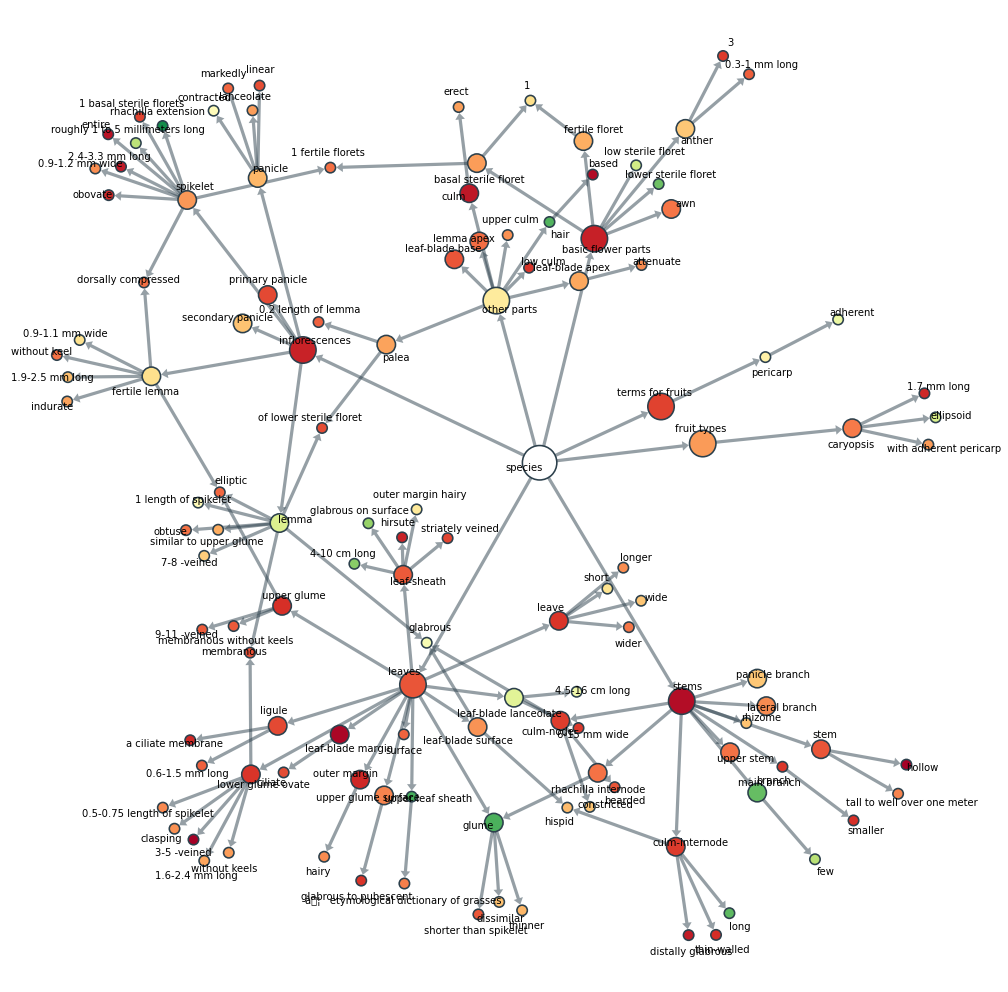

In [225]:
fig, ax = plt.subplots(figsize=(18, 18))
Graph(nodes, 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_labels=node_labels, 
      node_label_offset=0.04, 
      node_label_fontdict=dict(size=10, rotation=0, ha='center', clip_on=False), node_edge_width=0.4,
      node_size=node_size,  node_color=node_color, #edge_labels=edge_labels,
      edge_width=0.8, edge_label_fontdict=dict(size=5,),
      ax=ax)

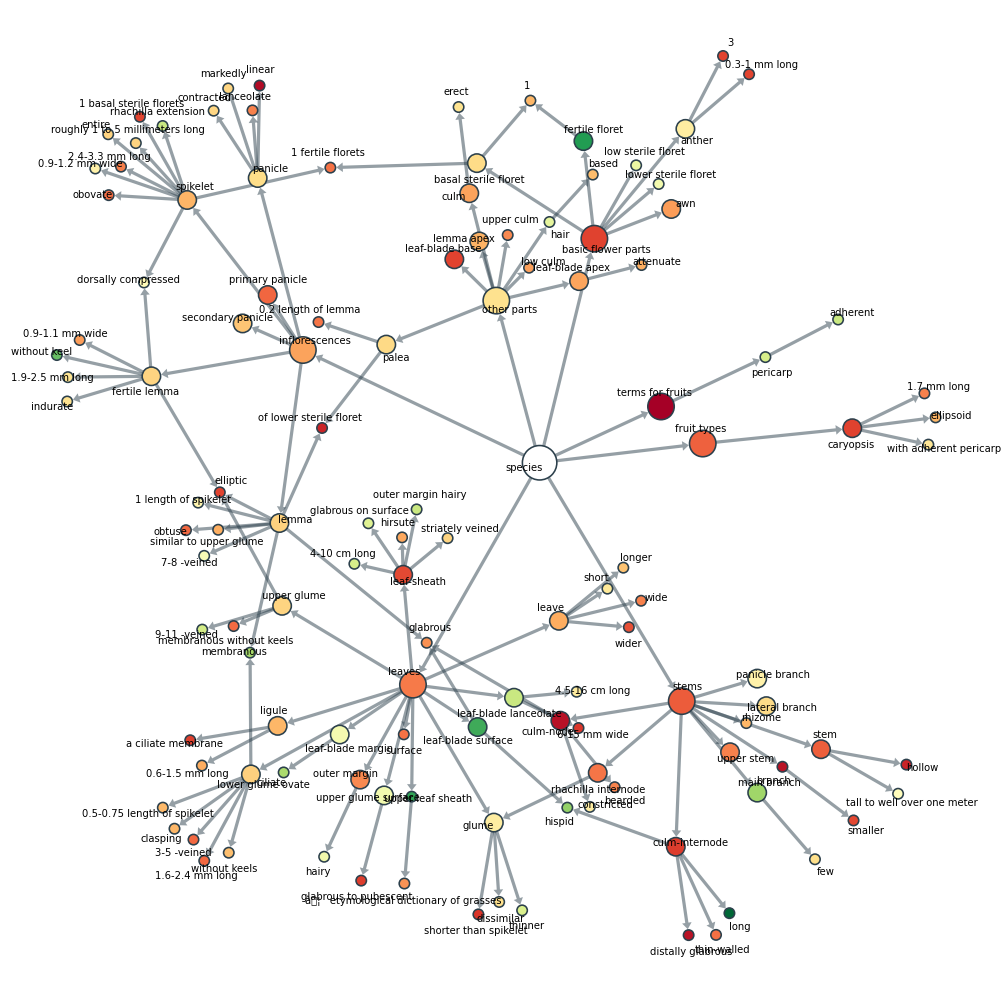

In [242]:
fig, ax = plt.subplots(figsize=(18, 18))
Graph(nodes, 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_labels=node_labels, 
      node_label_offset=0.04, 
      node_label_fontdict=dict(size=10, rotation=0, ha='center', clip_on=False), node_edge_width=0.4,
      node_size=node_size,  node_color=node_color, #edge_labels=edge_labels,
      edge_width=0.8, edge_label_fontdict=dict(size=5,),
      ax=ax)